In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(123)

# dictionary beta, n_tw

FILE_NAME = './ps4_data/abstract_nips21_NIPS2008_0517.txt.ready'

NUM_TOPIC = 0
ALPHA = []
BETA = {}
dic_id = {}
id_dic = {}
doc = []
count = {}

def read_file(f):
    with open(f, 'rb') as f_des:
        line = f_des.readline()
        NUM_TOPIC = int(line.replace('\n', ''))

        line = f_des.readline()
        ALPHA = [float(i) for i in line.replace('\n', '').split()]

        BETA = {}
        lines = f_des.readlines()

        idx = 0
        for line in lines:
            line = line.replace('\n', '').split()
            word = line[0]
            if word in dic_id.keys():  
                count[dic_id[word]] += 1
            else:
                dic_id[word] = idx
                id_dic[idx] = word
                idx += 1
                count[dic_id[word]] = 1
                assert NUM_TOPIC == len(line[1:])
                BETA[dic_id[word]] = [float(i) for i in line[1:]]

            doc.append(dic_id[word])

    return NUM_TOPIC, ALPHA, BETA, dic_id, id_dic, doc, count

def collapsed_gibbs_sampler(iter, alpha, beta):
    # iter: number of iterations
    theta = np.random.dirichlet(alpha)
    z = np.random.multinomial(len(doc), theta)

    n_t = np.zeros(len(alpha))
    n_tw = np.zeros([len(alpha), len(dic_id)])
    for i in range(len(alpha)):
        n_t[i] = np.sum(z == i)
    for i in range(len(alpha)):
        for j in id_dic:
            n_tw[i][j] = np.sum(np.logical_and(doc == j, z == i))

    res= {}
    sample_order = np.arange(len(doc))
    for ite in xrange(iter):
        t_res = np.zeros(len(doc))
        np.random.shuffle(sample_order)
        for i in sample_order:
            # p_val
            p_val = np.zeros(len(alpha))
            n_t[z[i]] -= 1
            for k in range(len(alpha)):
                p_val[k] = (n_t[k] + alpha[k]) * beta[doc[i]][k]
            # print p_val
            p_val[k] /= np.sum(p_val)
            p_val = np.cumsum(p_val)
            z_i = (p_val > np.random.uniform()).argmax() # z_i = np.random.multinomial(1, p_val)

            n_t[z_i] += 1
            t_res[i] = z_i
        res[ite] = t_res
    return res

In [2]:
NUM_TOPIC, ALPHA, BETA, dic_id, id_dic, doc, count = read_file(FILE_NAME)

print len(BETA), len(dic_id), len(id_dic), len(doc), len(count)

65 65 65 83 65


In [ ]:
ite = 1e4
samples = collapsed_gibbs_sampler(int(ite), ALPHA, BETA)

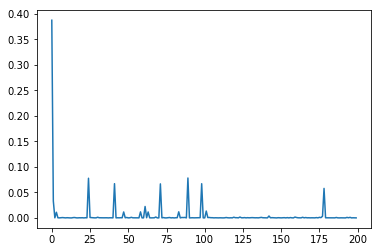

In [5]:
post_theta = np.zeros(len(ALPHA))
for i in samples.keys()[50:]:
    for j in range(len(doc)):
        post_theta[int(samples[i][j])] += 1
ite -= 50
normalizer = ite * (np.sum(ALPHA) + len(doc))
post_theta += ite * np.array(ALPHA)
post_theta /= normalizer

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(post_theta)
plt.show()

In [6]:
np.sum(post_theta)

1.0

In [10]:
def square_error(l1, l2):
    assert len(l1) == len(l2)
    res = 0
    for i in range(len(l1)):
        res += (l1[i] - l2[i]) ** 2
    return res
l1 = [1,2,3]
l2 = [0,0,0]
square_error(l1, l2)

14

In [24]:
def comp_dist(samples):
    res = {}
    t_res = np.zeros(len(ALPHA))
    for i in samples.keys()[50:]:
        for j in range(len(doc)):
            t_res[int(samples[i][j])] += 1
        ite = i - 49
        normalizer = ite * (np.sum(ALPHA) + len(doc))
        post_theta = t_res + ite * np.array(ALPHA)
        post_theta /= normalizer
        assert np.abs(np.sum(post_theta) - 1.0) < 1e-6
        res[i] = post_theta
    return res
sample_theta = comp_dist(samples)

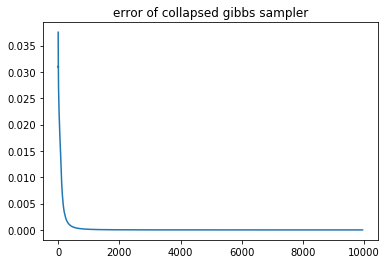

In [29]:
sq_err = []
for i in sample_theta.keys():
    sq_err.append(square_error(sample_theta[i], post_theta))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sq_err)
plt.title('error of collapsed gibbs sampler')
plt.show()

In [50]:
def gibbs_sampler(iter, alpha, beta):
    theta = np.random.dirichlet(alpha)
    res, res_theta = {}, {}
    sample_order = np.arange(len(doc))
    for ite in xrange(iter):
        n_t = np.zeros(len(alpha))
        np.random.shuffle(sample_order)
        for i in sample_order:
            # post of z
            p_val = np.zeros(len(alpha))
            for k in range(len(alpha)):
                p_val[k] = theta[k] * beta[doc[i]][k]
            # sample z
            p_val[k] /= np.sum(p_val)
            p_val = np.cumsum(p_val)
            z_i = (p_val > np.random.uniform()).argmax() # z_i = np.random.multinomial(1, p_val)

            n_t[z_i] += 1
        res[ite] = n_t + alpha
        theta = np.random.dirichlet(res[ite])
        res_theta[ite] = theta
    return res, res_theta

ite = 1e4
g_samples, g_theta = gibbs_sampler(int(ite), ALPHA, BETA)

In [46]:
g_dist = {}
sum_dist = np.zeros(len(ALPHA))
for i in g_samples.keys()[50:]:
    ite = i - 49
    sum_dist += g_samples[i] / np.sum(g_samples[i])
    g_dist[i] = sum_dist / ite

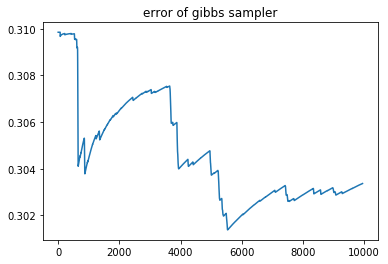

In [47]:
sq_err = []
for i in g_dist.keys():
    sq_err.append(square_error(g_dist[i], post_theta))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sq_err)
plt.title('error of gibbs sampler')
plt.show()

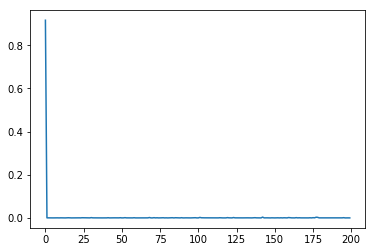

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(g_dist[50])
plt.show()

In [49]:
np.sum(g_dist[50])

1.0000000000000002